## Lab 3

### Part 1. NN from scratch and MNIST warmup (1 point)

__This part is connected with assignment0_05, you will need to finish it firts. If it is not finished yet, you can work on the next parts.__


Please, go to the `week0_08` directory and fill the `main_notebook.ipynb`. Then hand in the completed notebook.

If you already done that (e.g. while working on assignment0_05), there is small update in there (which requires you to achieve same results with PyTorch network). Update the notebook or read the notebook in the web version.

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

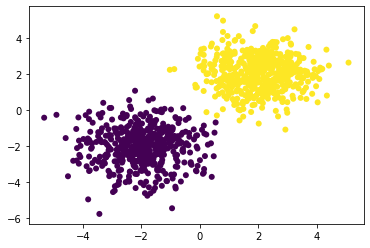

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

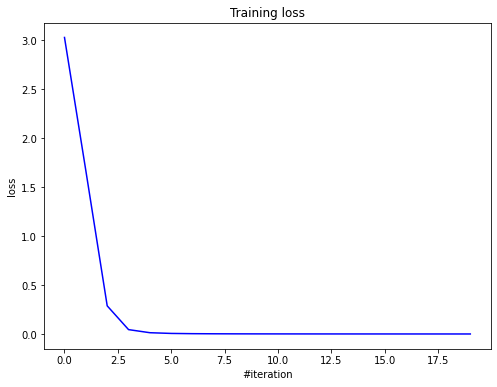

Current loss: 0.001060


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
n_in = X_train[0].size

One-hot encode the labels first.

In [10]:
def one_hot(y):
    u = np.unique(y).size
    oh = np.zeros((y.size, u))
    oh[range(y.size), y] = 1
    return oh

In [11]:
y_train.shape, y_val.shape, y_test.shape

((50000,), (10000,), (10000,))

In [12]:
y_train_orig, y_val_orig, y_test_orig = y_train, y_val, y_test
y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

In [13]:
n_out = y_train.shape[1]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [14]:
def train_by_one_epoch(
    net: Sequential,
    X_train: np.array,
    y_train: np.array,
    batch_size: int,
    optimizer_config: dict,
    optimizer_state: dict,
    optimizer,
    criterion: Criterion
):
    net.train() # don't forget about BatchNormalization and Dropout layers
    loss = 0
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        dp = criterion.backward(predictions, y_batch) 
        net.backward(x_batch, dp)
        optimizer(
            net.getParameters(),
            net.getGradParameters(),
            optimizer_config,
            optimizer_state
        )
        loss += criterion.forward(predictions, y_batch) * x_batch.shape[0]
    loss /= X_train.shape[0]
    return net, loss

In [15]:
def val_by_one_epoch(
    net: Sequential,
    X_val: np.array,
    y_val: np.array,
    batch_size: int,
    criterion: Criterion
):
    net.evaluate() # don't forget about BatchNormalization and Dropout layers
    loss = 0
    for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
        predictions = net.forward(x_batch)
        loss += criterion.forward(predictions, y_batch) * x_batch.shape[0]
    loss /= X_train.shape[0]
    return net, loss

In [16]:
def calc_accuracy(    
    net: Sequential,
    X: np.array,
    y: np.array,
    batch_size: int
):
    net.evaluate() # don't forget about BatchNormalization and Dropout layers
    successful_predictions = 0
    for x_batch, y_batch in get_batches((X, y), batch_size):
        predictions = net.forward(x_batch)
        successful_predictions += (
            predictions.argmax(axis=1) == y_batch.argmax(axis=1)
        ).sum()
    accuracy = successful_predictions / X.shape[0]
    return net, accuracy

In [17]:
def train_model(
    net: Sequential,
    X_train: np.array,
    y_train: np.array,
    X_val: np.array,
    y_val: np.array,
    batch_size: int,
    optimizer_config: dict,
    optimizer_state: dict,
    optimizer,
    n_epochs: int,
    criterion: Criterion=ClassNLLCriterion(),
    verbose: bool=False
):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(n_epochs):
        start_time = time()
        net, train_loss = train_by_one_epoch(
            net, 
            X_train, 
            y_train, 
            batch_size, 
            optimizer_config, 
            optimizer_state,
            optimizer, 
            criterion
        )
        train_losses.append(train_loss)
        net, val_loss = val_by_one_epoch(
            net,
            X_val,
            y_val,
            batch_size,
            criterion
        )
        val_losses.append(val_loss)
        net, val_accuracy = calc_accuracy(
            net, 
            X_val, 
            y_val, 
            batch_size
        )
        val_accuracies.append(val_accuracy)
        if verbose:
            print(f'Epoch {epoch + 1} of {n_epochs} took {time() - start_time:.3f}s')
    return net, train_losses, val_losses, val_accuracies

In [18]:
def plot_train_process(
    train_losses: list,
    val_losses: list,
    val_accuracies: list,
    title_extra: str=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title(f'Loss {title_extra}')
    axes[0].plot(train_losses, label='train')
    axes[0].plot(val_losses, label='validation')
    axes[0].legend()
    axes[1].set_title(f'Validation accuracy {title_extra}')
    axes[1].plot(val_accuracies)

In [19]:
activations = (ReLU, LeakyReLU, ELU, SoftPlus)

In [20]:
activations_labels = [activation.__name__ for activation in activations]

In [21]:
experiments = {}

Firstly, try simple model with SGD optimizer with each activation function.

Computation time with ReLU & SGD took 77.788s
Computation time with LeakyReLU & SGD took 72.676s
Computation time with ELU & SGD took 73.558s
Computation time with SoftPlus & SGD took 69.389s


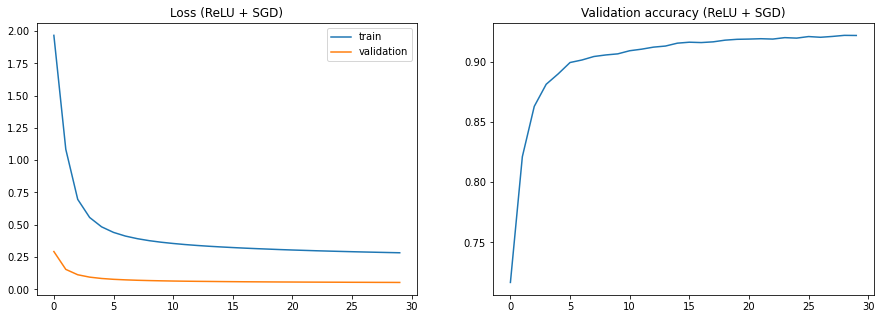

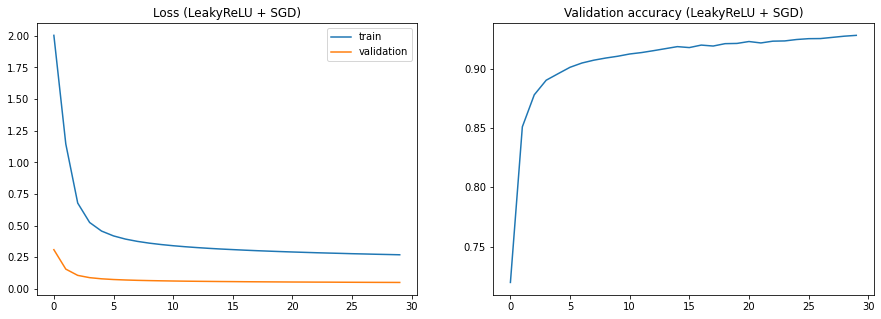

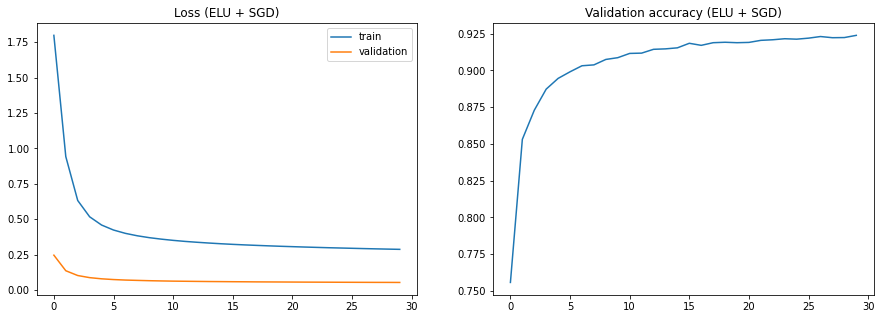

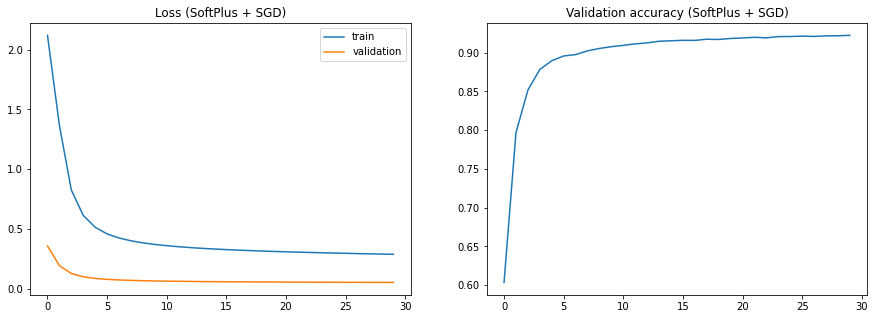

In [22]:
for act, act_lb in zip(activations, activations_labels):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(n_in, 16))
    net.add(act())
    net.add(Linear(16, n_out))
    net.add(LogSoftMax())
    start_time = time()
    net, train_losses, val_losses, val_accuracies = train_model(
        net=net,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        batch_size=128,
        optimizer_config={'learning_rate' : 1e-3, 'momentum': 0.9},
        optimizer_state={},
        optimizer=sgd_momentum,
        n_epochs=30
    )
    print(f'Computation time with {act_lb} & SGD took {time() - start_time:.3f}s')
    plot_train_process(train_losses, val_losses, val_accuracies, f"({act_lb} + SGD)")
    experiments[f"{act_lb} + SGD"] = {
        "train losses": train_losses,
        "validation losses": val_losses,
        "validation accuracies": val_accuracies
    }

Secondly, try the same model again, but with Adam optimizer.

Computation time with ReLU & Adam took 67.612s
Computation time with LeakyReLU & Adam took 70.769s
Computation time with ELU & Adam took 69.008s
Computation time with SoftPlus & Adam took 71.137s


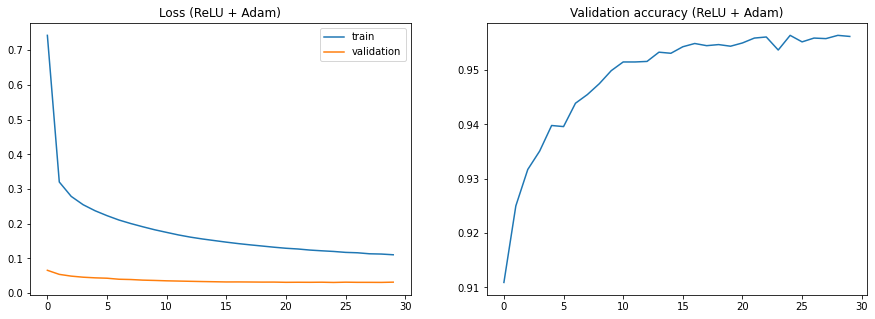

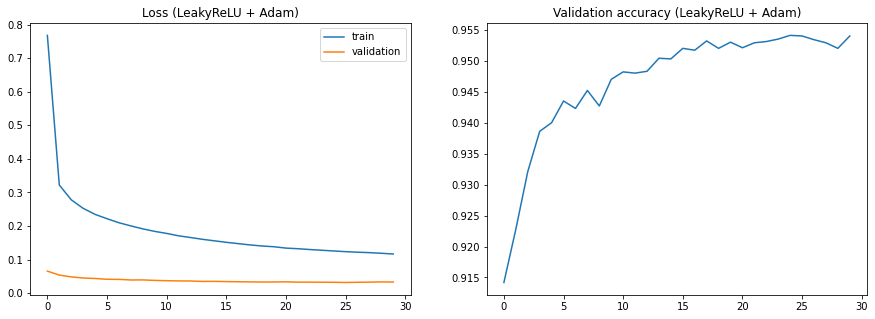

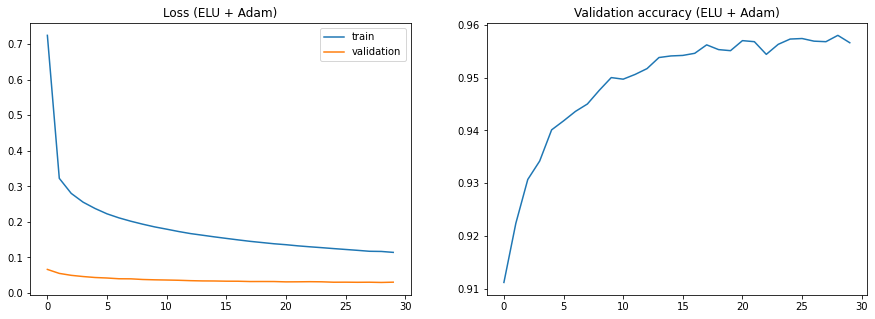

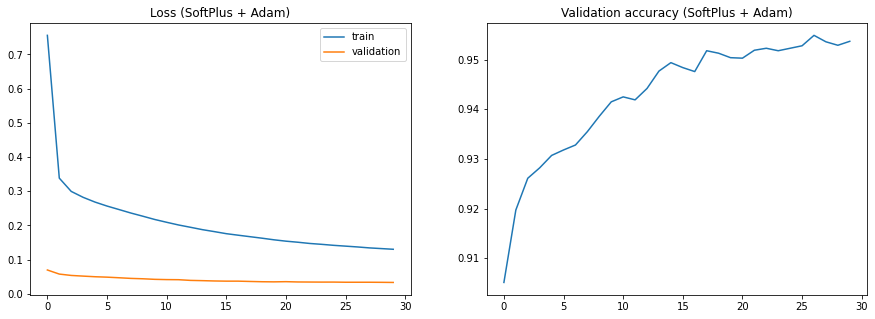

In [23]:
for act, act_lb in zip(activations, activations_labels):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(n_in, 16))
    net.add(act())
    net.add(Linear(16, n_out))
    net.add(LogSoftMax())
    start_time = time()
    net, train_losses, val_losses, val_accuracies = train_model(
        net=net,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        batch_size=128,
        optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8},
        optimizer_state={},
        optimizer=adam_optimizer,
        n_epochs=30
    )
    print(f'Computation time with {act_lb} & Adam took {time() - start_time:.3f}s')
    plot_train_process(train_losses, val_losses, val_accuracies, f"({act_lb} + Adam)")
    experiments[f"{act_lb} + Adam"] = {
        "train losses": train_losses,
        "validation losses": val_losses,
        "validation accuracies": val_accuracies
    }

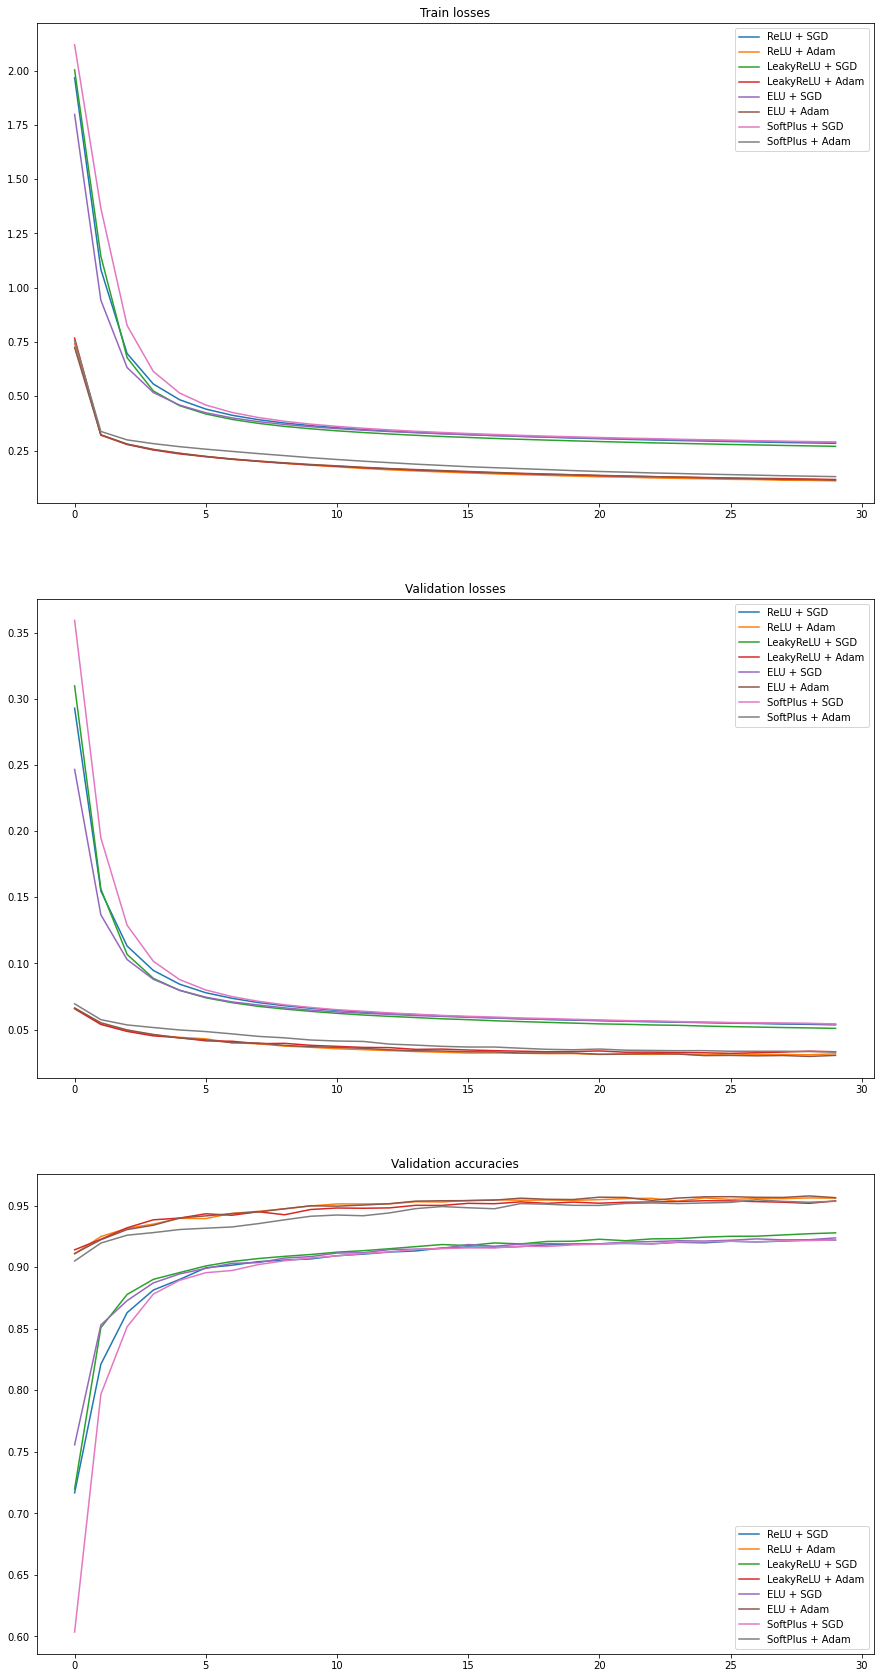

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(15, 30))
titles = ['train losses', 'validation losses', 'validation accuracies']
for act_lb in activations_labels:
    for opt_lb in ['SGD', 'Adam']:
        exp_key = f'{act_lb} + {opt_lb}'
        for i, title in enumerate(titles):
            axes[i].plot(experiments[exp_key][title], label=exp_key)
for i, title in enumerate(titles):
    axes[i].set_title(title.capitalize())
    axes[i].legend()

Adam is an optimization algorithm that can be used instead of the classical SGD procedure to update network weights iterative based in training data, so with the same learning rate (~ $10^{-3}$) showed better performance time on each launch and especially with ReLU. 
And this is consistent with theoretical findings and common sense. Moreover, loss and accuracy is better when Adam is used instead of SGD.

In [41]:
from operator import itemgetter
from pprint import pprint

train_losses = []
validation_losses = []
validation_accuracies = []

for experiment in experiments:
    train_losses.append((np.mean(experiments[experiment]['train losses']), experiment))
    validation_losses.append((np.mean(experiments[experiment]['validation losses']), experiment))
    validation_accuracies.append((np.mean(experiments[experiment]['validation accuracies']), experiment))
    
print('Train losses:')
pprint(sorted(train_losses, key=itemgetter(0))[:3])
print('Validation losses:')
pprint(sorted(validation_losses, key=itemgetter(0))[:3])
print('Validation accuracies:')
pprint(sorted(validation_accuracies, key=itemgetter(0), reverse=True)[:3])

Train losses:
[(0.18476761695249216, 'ReLU + Adam'),
 (0.18818518146290553, 'ELU + Adam'),
 (0.18891920776728474, 'LeakyReLU + Adam')]
Validation losses:
[(0.036605103319068015, 'ReLU + Adam'),
 (0.03676509893023342, 'ELU + Adam'),
 (0.03781401209337841, 'LeakyReLU + Adam')]
Validation accuracies:
[(0.94898, 'ELU + Adam'),
 (0.9486433333333332, 'ReLU + Adam'),
 (0.9469166666666666, 'LeakyReLU + Adam')]


`ReLU` is the best in most cases according to the loss and accuracy. 

Now let's move on more complex models. Try inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.  
Plot the losses both from activation functions comparison and BatchNormalization comparison on one plot.  
Let's use `ReLU` and `Adam` for following models.

Computation time with ReLU & Adam took 95.675s
Computation time with ReLU & Adam & BatchNorm took 91.197s


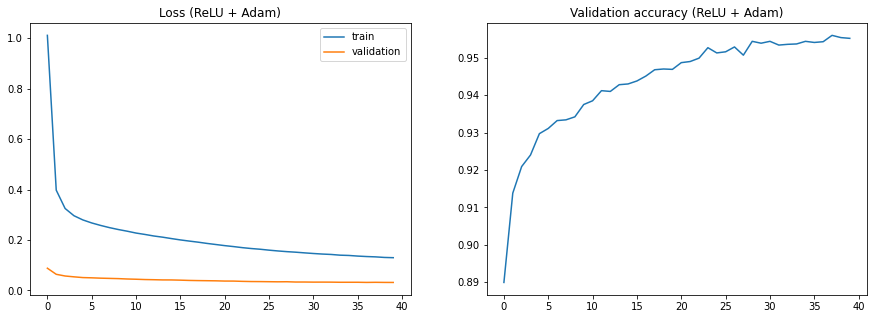

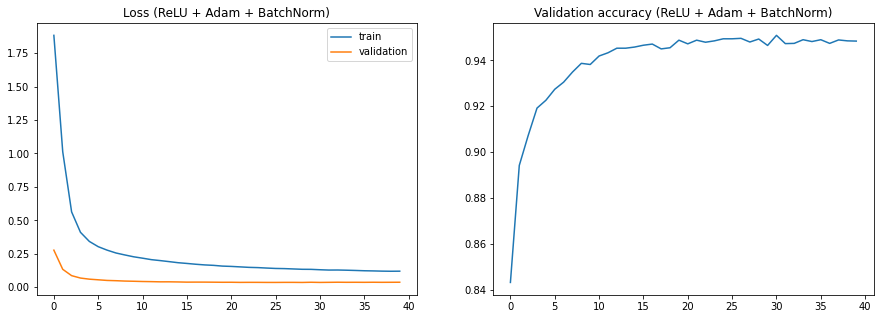

In [45]:
experiments = {} # reset our experiments storage

for make_more_complex in [False, True]:
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(n_in, 16))
    if make_more_complex:
        net.add(BatchNormalization(alpha=0.9))
        net.add(ChannelwiseScaling(16))
    net.add(ReLU())
    net.add(Linear(16, n_out))
    net.add(LogSoftMax())
    start_time = time()
    net, train_losses, val_losses, val_accuracies = train_model(
        net=net,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        batch_size=256,
        optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8},
        optimizer_state={},
        optimizer=adam_optimizer,
        n_epochs=40
    )
    print(f"Computation time with ReLU & Adam{' & BatchNorm' if make_more_complex else ''} took {time() - start_time:.3f}s")
    plot_train_process(
        train_losses, 
        val_losses, 
        val_accuracies,
        f"(ReLU + Adam{' + BatchNorm' if make_more_complex else ''})"
    )
    experiments[make_more_complex] = {
        "train losses": train_losses,
        "validation losses": val_losses,
        "validation accuracies": val_accuracies
    }

In [51]:
for make_more_complex in [False, True]:
    print(f"With{'' if make_more_complex else 'out'} batch normalization:")
    print("\ttrain losses: ", np.mean(experiments[make_more_complex]["train losses"]))
    print("\tvalidation losses: ", np.mean(experiments[make_more_complex]["validation losses"]))
    print("\tvalidation accuracies: ", np.mean(experiments[make_more_complex]["validation accuracies"]))

Without batch normalization:
	train losses:  0.21502716352888235
	validation losses:  0.041028001301181935
	validation accuracies:  0.943585
With batch normalization:
	train losses:  0.2505180180399921
	validation losses:  0.0497838765789126
	validation accuracies:  0.9395075


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

`BatchNormalization` brought computation speed improvement and made a little worse accuracy and loss, as expected.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

Let's stack more layers:)  
And don't forget about Dropout to avoid overfitting.

In [80]:
prev_layer, next_layer = n_in, 32

net = Sequential()
net.add(Flatten())
for _ in range(5):
    net.add(Linear(prev_layer, next_layer))
    net.add(BatchNormalization(alpha=0.9))
    net.add(ChannelwiseScaling(next_layer))
    net.add(ReLU())
    net.add(Dropout(p=0.5))
    prev_layer, next_layer = next_layer, next_layer * 2
net.add(Linear(prev_layer, n_out))
net.add(LogSoftMax())

In [81]:
batch_size = 512

In [82]:
%%time
net, train_losses, val_losses, val_accuracies = train_model(
    net=net,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=batch_size,
    optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8},
    optimizer_state={},
    optimizer=adam_optimizer,
    n_epochs=20,
    criterion=ClassNLLCriterion(),
    verbose=True
)

Epoch 1 of 20 took 52.992s
Epoch 2 of 20 took 51.592s
Epoch 3 of 20 took 56.384s
Epoch 4 of 20 took 54.718s
Epoch 5 of 20 took 55.101s
Epoch 6 of 20 took 52.971s
Epoch 7 of 20 took 51.502s
Epoch 8 of 20 took 54.556s
Epoch 9 of 20 took 48.757s
Epoch 10 of 20 took 48.355s
Epoch 11 of 20 took 50.695s
Epoch 12 of 20 took 53.256s
Epoch 13 of 20 took 59.109s
Epoch 14 of 20 took 57.757s
Epoch 15 of 20 took 50.709s
Epoch 16 of 20 took 49.322s
Epoch 17 of 20 took 55.627s
Epoch 18 of 20 took 59.427s
Epoch 19 of 20 took 70.753s
Epoch 20 of 20 took 59.148s
CPU times: user 27min 19s, sys: 24min 48s, total: 52min 7s
Wall time: 18min 12s


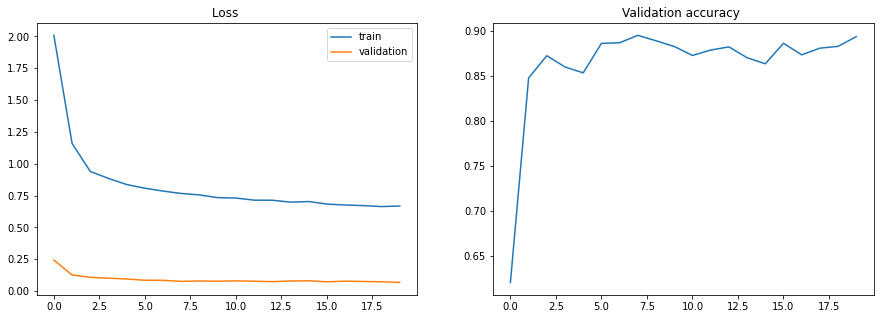

In [83]:
plot_train_process(train_losses, val_losses, val_accuracies)

Print here your accuracy on test set. It should be around 90%.

In [91]:
net, accuracy = calc_accuracy(net=net, X=X_test, y=y_test, batch_size=batch_size)

print(f"You're breathtaking, accuracy is around 90%: {accuracy*100}%")

You're breathtaking, accuracy is around 90%: 88.75%


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [92]:
import time

import torch
from torch import nn
from torch.nn import functional as F

In [93]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [94]:
def train_model(
    model, 
    X_train: np.array, 
    y_train: np.array,
    X_val: np.array, 
    y_val: np.array, 
    batch_size: int, 
    loss_fn, 
    opt,
    n_epochs: int
):
    '''
    model:    NN to train
    X_train:  np.array 
    y_train:  np.array
    X_val:    np.array 
    y_val:    np.array 
    loss_fn:  loss function for optimizing
    opt:      optimizer update NN's weights
    n_epochs: number of epochs
    '''
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
            opt.zero_grad()
            # move data to target device
            X_batch = torch.from_numpy(X_batch).to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in get_batches((X_val, y_val), batch_size):
                # move data to target device
                X_batch = torch.from_numpy(X_batch).to(device)
                y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)
                # compute predictions
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean( 
                    (y_batch.cpu() == y_pred.cpu()).numpy() 
                ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t      training loss: {train_loss[-1]:.6f}")
        print(f"\t    validation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [95]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(28**2, 400),
    nn.ReLU(),
    nn.Linear(400, 10),
    nn.LogSoftmax(),
)
model.to(device, torch.float32)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=10, bias=True)
  (3): LogSoftmax()
)

In [96]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [97]:
n_epochs = 30
batch_size = 32

In [98]:
%%time
train_loss, val_loss, val_accuracy = train_model(
    model=model,
    X_train=X_train.reshape(len(X_train), -1),         
    y_train=y_train_orig, 
    X_val=X_val.reshape(len(X_val), -1),         
    y_val=y_val_orig,
    batch_size=batch_size,
    loss_fn=loss_fn,
    opt=opt, 
    n_epochs=n_epochs
)

/home/mvcibuntu/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 of 30 took 16.546s
	      training loss: 0.259936
	    validation loss: 0.130722
	validation accuracy: 0.963
Epoch 2 of 30 took 20.234s
	      training loss: 0.102018
	    validation loss: 0.090971
	validation accuracy: 0.973
Epoch 3 of 30 took 18.230s
	      training loss: 0.067249
	    validation loss: 0.082408
	validation accuracy: 0.975
Epoch 4 of 30 took 18.171s
	      training loss: 0.044826
	    validation loss: 0.079200
	validation accuracy: 0.977
Epoch 5 of 30 took 19.793s
	      training loss: 0.033523
	    validation loss: 0.072469
	validation accuracy: 0.980
Epoch 6 of 30 took 16.917s
	      training loss: 0.024002
	    validation loss: 0.082939
	validation accuracy: 0.978
Epoch 7 of 30 took 18.034s
	      training loss: 0.018581
	    validation loss: 0.086203
	validation accuracy: 0.978
Epoch 8 of 30 took 21.868s
	      training loss: 0.014928
	    validation loss: 0.094995
	validation accuracy: 0.975
Epoch 9 of 30 took 20.514s
	      training loss: 0.012137
	    v

In [99]:
def test_model(
    model,
    X_test: np.array, 
    y_test: np.array, 
    batch_size: int,
    loss_fn
):
    test_loss = []
    test_accuracy = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
            # move data to target device
            X_batch = torch.from_numpy(X_batch).to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)
            # compute predictions
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            test_loss.append(loss.item())
            y_pred = predictions.max(1)[1].data
            test_accuracy.append(np.mean( 
                (y_batch.cpu() == y_pred.cpu()).numpy() 
            ))
    
    print(f"\t    test loss: {test_loss[-1]:.6f}")
    print(f"\ttest accuracy: {test_accuracy[-1]:.3f}")
    
    return test_loss, test_accuracy

In [100]:
%%time
test_loss, test_accuracy = test_model(
    model=model,
    X_test=X_test.reshape(len(X_test), -1),         
    y_test=y_test_orig,
    batch_size=batch_size,
    loss_fn=loss_fn
)

/home/mvcibuntu/.local/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


	    test loss: 0.036515
	test accuracy: 1.000
CPU times: user 414 ms, sys: 112 ms, total: 526 ms
Wall time: 439 ms


Wow, we reached 100% prediction on the last batch, but let's have a look how it worked on full test dataset.

In [101]:
print(f"""
test accuracy: {np.mean(test_accuracy)}
    test loss: {np.mean(test_loss)}
""")


test accuracy: 0.9794329073482428
    test loss: 0.13801227679874373



## Conclusion    
*  We have implemented out toy-framework for creating NN.
*  Compared activation functions: `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus`, on performance, loss and accuracy. ReLU and LeakyReLU are the most appropriate.
*  Convinced of the benefits of the Adam in comparsion with SGD.
*  Used BatchNormalization to improve performance.